<a href="https://colab.research.google.com/github/bshazia/Apple_Stocks/blob/main/Apple_stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
!pip install yfinance==0.2.12

[link text](https://)**Step 1: Data Collection**

In [29]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet import Prophet
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
import datetime
from tensorflow.keras.layers import Input,LSTM
from tensorflow.keras.models import Sequential



In [15]:
#daily data for past 10 years
data_daily_copy = yf.download("AAPL", period="10y", interval="1d")
data_daily_copy.to_csv('AAPL_daily_data.csv')

#monthly data for past 10 years
data_monthly = yf.download("AAPL", period="10y", interval="1mo")
data_monthly.to_csv('AAPL_monthly_data.csv')


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [16]:
data_daily_copy.sample(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-05-04,32.375000,32.642502,32.064999,32.174999,28.838869,203953200
2015-04-10,31.487499,31.802500,31.315001,31.775000,28.480354,160752000
2016-08-17,27.275000,27.342501,27.084999,27.305000,25.215136,101424000
2015-02-05,30.004999,30.057501,29.812500,29.985001,26.875948,168984800
2016-01-15,24.049999,24.427500,23.840000,24.282499,22.048542,319335600


Step 2: Data Preprocessing

In [4]:
data_daily_copy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2014-08-11 to 2024-08-08
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2516 non-null   float64
 1   High       2516 non-null   float64
 2   Low        2516 non-null   float64
 3   Close      2516 non-null   float64
 4   Adj Close  2516 non-null   float64
 5   Volume     2516 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 137.6 KB


In [17]:
#remove one week
one_week_ago = datetime.date.today() - datetime.timedelta(days=7)

data_daily = data_daily_copy[data_daily_copy.index < pd.Timestamp(one_week_ago)]

data_daily.to_csv('AAPL_data_daily_Week_back.csv')

In [20]:
data_monthly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 2014-09-01 to 2024-08-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       120 non-null    float64
 1   High       120 non-null    float64
 2   Low        120 non-null    float64
 3   Close      120 non-null    float64
 4   Adj Close  120 non-null    float64
 5   Volume     120 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 6.6 KB


In [18]:
# Check for missing dates in daily data
all_dates_daily = pd.date_range(start=data_daily.index.min(), end=data_daily.index.max(), freq='D')
missing_dates_daily = all_dates_daily.difference(data_daily.index)
print("Missing dates in daily data:", missing_dates_daily)
print("Number of missing dates in daily data:", missing_dates_daily.size)

# Check for missing dates in monthly data
all_dates_monthly = pd.date_range(start=data_monthly.index.min(), end=data_monthly.index.max(), freq='M')
missing_dates_monthly = all_dates_monthly.difference(data_monthly.index)
print("Missing dates in monthly data:", missing_dates_monthly)
print("Number of missing dates in monthly data:", missing_dates_monthly.size)

Missing dates in daily data: DatetimeIndex(['2014-08-16', '2014-08-17', '2014-08-23', '2014-08-24',
               '2014-08-30', '2014-08-31', '2014-09-01', '2014-09-06',
               '2014-09-07', '2014-09-13',
               ...
               '2024-06-30', '2024-07-04', '2024-07-06', '2024-07-07',
               '2024-07-13', '2024-07-14', '2024-07-20', '2024-07-21',
               '2024-07-27', '2024-07-28'],
              dtype='datetime64[ns]', length=1133, freq=None)
Number of missing dates in daily data: 1133
Missing dates in monthly data: DatetimeIndex(['2014-09-30', '2014-10-31', '2014-11-30', '2014-12-31',
               '2015-01-31', '2015-02-28', '2015-03-31', '2015-04-30',
               '2015-05-31', '2015-06-30',
               ...
               '2023-10-31', '2023-11-30', '2023-12-31', '2024-01-31',
               '2024-02-29', '2024-03-31', '2024-04-30', '2024-05-31',
               '2024-06-30', '2024-07-31'],
              dtype='datetime64[ns]', length=119, freq

In [7]:
#lets verify it with market calendar
!pip install pandas_market_calendars
import pandas_market_calendars as mcal

nyse = mcal.get_calendar('NYSE')

trading_days = nyse.schedule(start_date=data_daily.index.min(), end_date=data_daily.index.max())

non_trading_days = missing_dates_daily[~missing_dates_daily.isin(trading_days.index)]

print("Number of missing dates that are non-trading days:", non_trading_days.size)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.3/107.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.1/196.1 kB 9.6 MB/s eta 0:00:00
Number of missing dates that are non-trading days: 1133


these are non-trading days and it's not impacting our data integrity
\

In [19]:
data_daily.loc[:, 'Close_Lag1'] = data_daily['Close'].shift(1)
data_daily.loc[:, 'Close_MA5'] = data_daily['Close'].rolling(window=5).mean()


<ipython-input-19-24286483bece>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_daily.loc[:, 'Close_Lag1'] = data_daily['Close'].shift(1)
<ipython-input-19-24286483bece>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_daily.loc[:, 'Close_MA5'] = data_daily['Close'].rolling(window=5).mean()


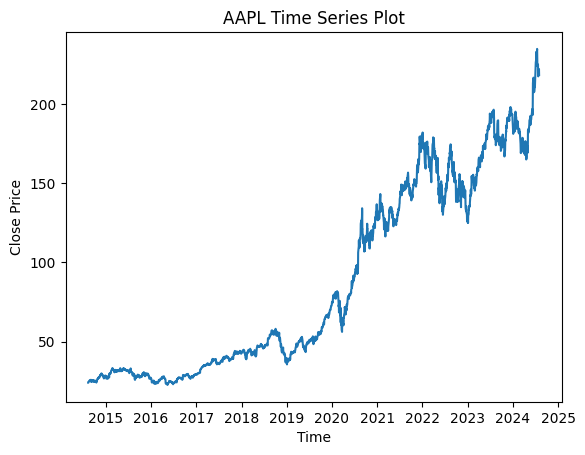

In [21]:
import matplotlib.pyplot as plt

plt.plot(data_daily['Close'])
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('AAPL Time Series Plot')
plt.show()


**Training**

In [22]:
features = ['Close_Lag1', 'Close_MA5']

x = data_daily[features]
y = data_daily['Close'][x.index]

In [24]:
x = x.dropna()
y = y[x.index]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)


In [25]:
X_train_lstm = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_lstm = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])


In [30]:
model_lstm = Sequential()
model_lstm.add(Input(shape=(1, X_train.shape[1])))
model_lstm.add(LSTM(70))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')


In [31]:
data_daily.shape


(2511, 8)

In [42]:
model_lstm.fit(X_train_lstm, y_train, epochs=100, batch_size=64)


Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 189.2874
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 196.9060
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 207.4518
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 167.2009
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 177.7350
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 171.5568
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 173.2571
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 169.9859
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 154.6099
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 146.6124
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 161.2426
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 156.4904
Epoch 13/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 138.2786
Epoch 14/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 131.4430
Epoch 15/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 

**Evaluation**

In [43]:
y_pred_lstm = model_lstm.predict(X_test_lstm)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [44]:
mse_lstm = mean_squared_error(y_test, y_pred_lstm.flatten())
rmse_lstm = mean_squared_error(y_test, y_pred_lstm.flatten(), squared=False)
mae_lstm = mean_absolute_error(y_test, y_pred_lstm.flatten())

print("LSTM - MSE:", mse_lstm, "RMSE:", rmse_lstm, "MAE:", mae_lstm)

LSTM - MSE: 595.7475068488648 RMSE: 24.407939422426974 MAE: 19.06865135891979


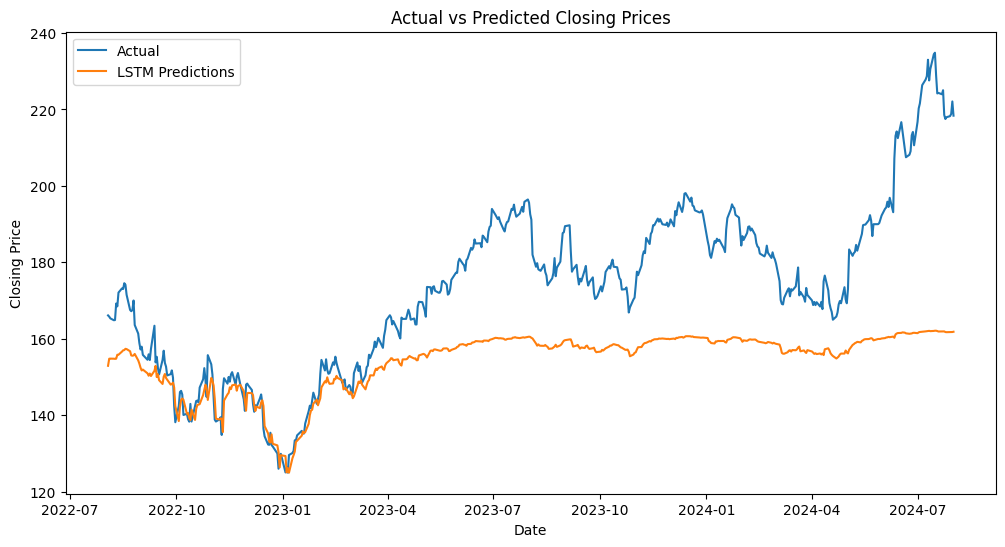

In [46]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred_lstm, label='LSTM Predictions')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Actual vs Predicted Closing Prices')
plt.legend()
plt.show()

cheking with prophit now

In [47]:
df_train = pd.DataFrame({'ds': X_train.index, 'y': y_train})
df_test = pd.DataFrame({'ds': X_test.index, 'y': y_test})

In [48]:
model_prophet = Prophet()
model_prophet.fit(df_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc258o3wg/_20rcai4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc258o3wg/08shg2ul.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12143', 'data', 'file=/tmp/tmpc258o3wg/_20rcai4.json', 'init=/tmp/tmpc258o3wg/08shg2ul.json', 'output', 'file=/tmp/tmpc258o3wg/prophet_modelft4drkw8/prophet_model-20240809051403.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:14:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:14:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [49]:
future = model_prophet.make_future_dataframe(periods=len(df_test))
forecast = model_prophet.predict(future)
y_pred_prophet = forecast['yhat'][-len(df_test):]

In [50]:

mse_prophet = mean_squared_error(y_test, y_pred_prophet)
rmse_prophet = mean_squared_error(y_test, y_pred_prophet, squared=False)
mae_prophet = mean_absolute_error(y_test, y_pred_prophet)

print("Prophet - MSE:", mse_prophet, "RMSE:", rmse_prophet, "MAE:", mae_prophet)

Prophet - MSE: 430.64595015493694 RMSE: 20.752010749682473 MAE: 17.035082033389465


Prophet model performance is better fit to the observed data and more accurate predictions than LSTM model

now let's compare them

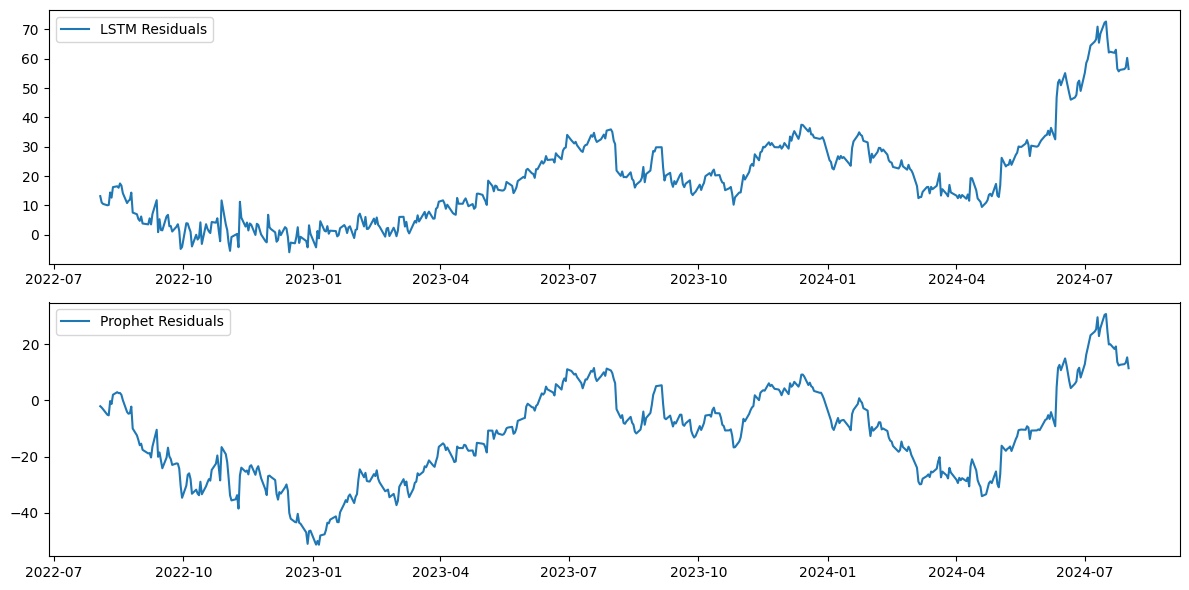

In [51]:
y_test_aligned = y_test.reset_index(drop=True)
y_pred_prophet_aligned = y_pred_prophet.reset_index(drop=True)

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(y_test.index, y_test - y_pred_lstm.flatten(), label='LSTM Residuals')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(y_test.index, y_test_aligned - y_pred_prophet_aligned, label='Prophet Residuals')
plt.legend()
plt.tight_layout()
plt.show()

Let's compare it with actual values

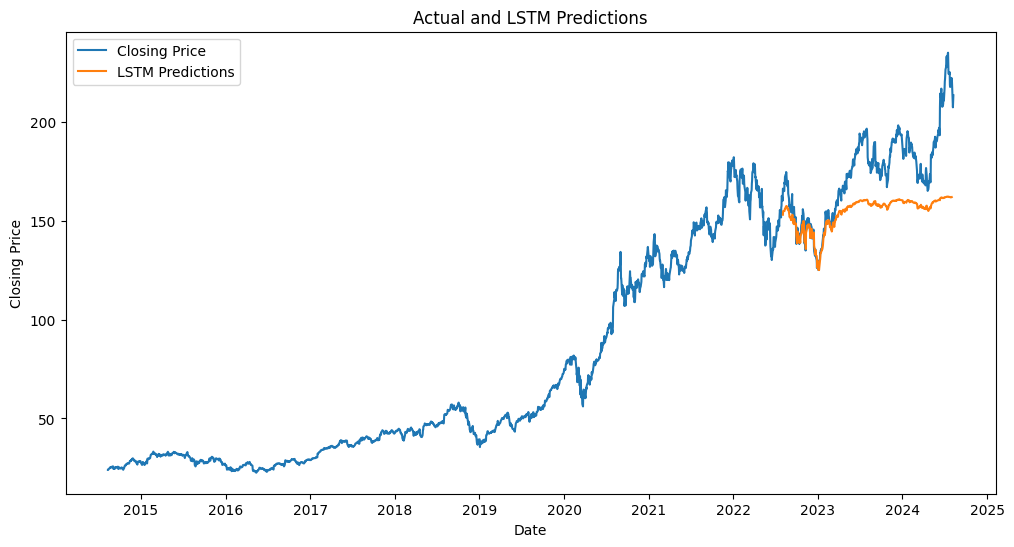

In [52]:
plt.figure(figsize=(12, 6))

#original data
plt.plot(data_daily_copy.index, data_daily_copy['Close'], label='Closing Price')

#trained Data
plt.plot(y_test.index, y_pred_lstm, label='LSTM Predictions')

plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Actual and LSTM Predictions')
plt.legend()
plt.show()